In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import torch
import pytorch_tabnet
from sklearn.preprocessing import LabelEncoder
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from sklearn.metrics import roc_auc_score

import missingno as msno

In [2]:
used_cols = {'passed', 'year', 'FirstLeadGender', 'SecondLeadGender', 'ThirdLeadGender','FourthLeadGender', 'budget', 'popularity','FirstLeadPop', 'SecondLeadPop', 'ThirdLeadPop','FourthLeadPop','vote_average','vote_count','genre','revenue','production','runtime'}

train = pd.read_csv('BechdelMovies_titles.csv', encoding = None, usecols = used_cols)

In [3]:
target = 'passed'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

In [4]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 50:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

passed 2
FirstLeadGender 4
SecondLeadGender 4
ThirdLeadGender 4
FourthLeadGender 4
genre 20
Set 3


In [5]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [6]:
max_epochs = 1000
lr_stepsz = 20 #Adjustable Learning Rate, Epochs to adjustment
lr_gamma = 0.9 #Amount of adjustment
pat = 20 #patience, # of decreasing epochs to wait for to stop early
nmasks = 3

tabnet_params = {"cat_idxs":cat_idxs,
                 "cat_dims":cat_dims,
                 "n_steps":nmasks,
                 "cat_emb_dim":1,
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{},
                 "scheduler_fn":torch.optim.lr_scheduler.ReduceLROnPlateau,
                 "mask_type":'sparsemax', # "entmax",
                 "verbose":0
                }

clf = TabNetClassifier(**tabnet_params
                      )

In [7]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]


Early stopping occurred at epoch 28 with best_epoch = 8 and best_valid_auc = 0.77557
Best weights from best epoch are automatically used!


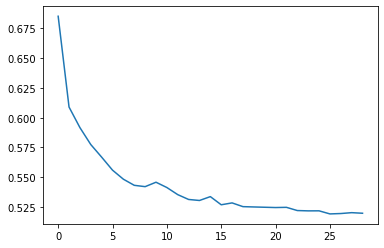

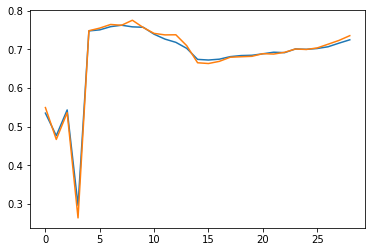

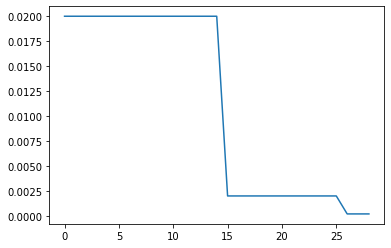


Early stopping occurred at epoch 119 with best_epoch = 99 and best_valid_auc = 0.8195
Best weights from best epoch are automatically used!


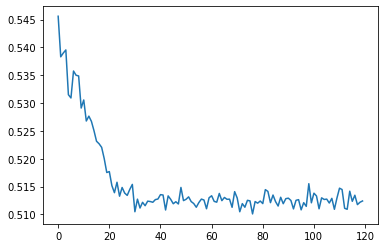

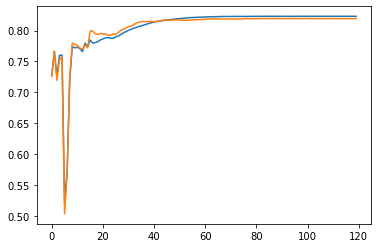

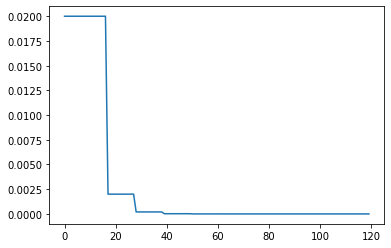

In [8]:
for _ in range(2):
    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'],
        eval_metric=['auc'],
        max_epochs=max_epochs , patience=pat,
        batch_size=1024, virtual_batch_size=256,
        num_workers=0,
        weights=0,
        drop_last=False
    )
    plt.plot(clf.history['loss'])
    plt.show()
    plt.plot(clf.history['train_auc'])
    plt.plot(clf.history['valid_auc'])
    plt.show()
    plt.plot(clf.history['lr'])
    plt.show()

In [9]:
dataset_name = 'bechdel'
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)


preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")

BEST VALID SCORE FOR bechdel : 0.8194954990705738
FINAL TEST SCORE FOR bechdel : 0.802442724927932


In [10]:
explain_matrix, masks = clf.explain(X_test)

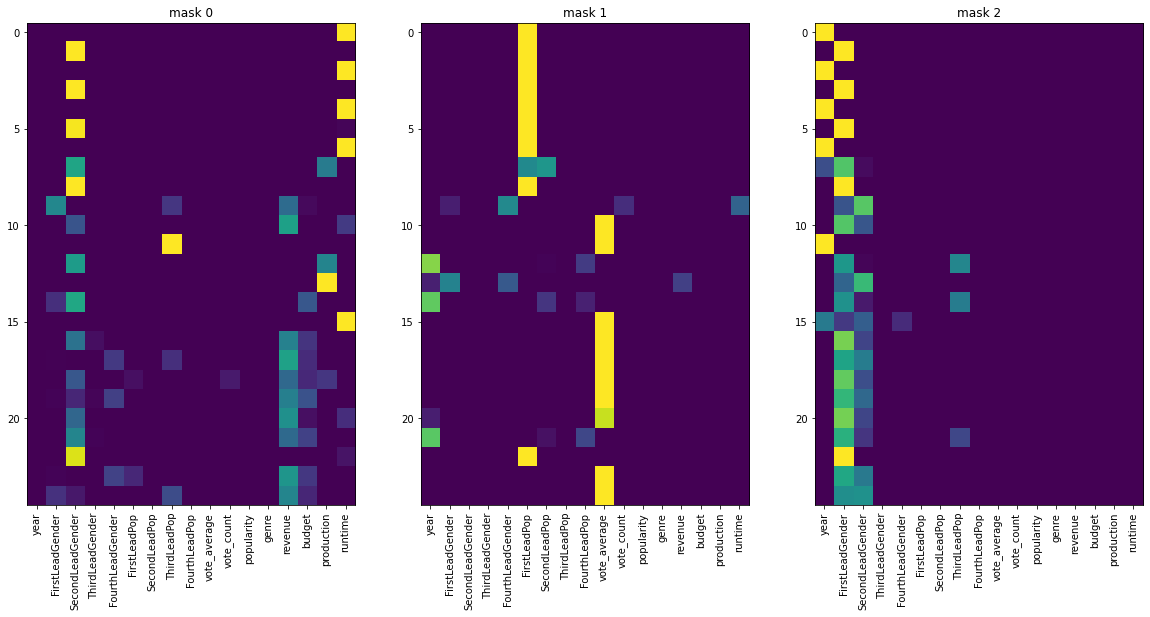

In [11]:
plts = nmasks  ## Equal to "n_steps"
fig, axs = plt.subplots (1,plts, figsize=(20,20))
for i in range(plts):
    if plts > 1:
        axs[i].imshow(masks[i][:25]) # # of examples
        axs[i].set_title(f"mask {i}")
        axs[i].xaxis.set_ticks(range(len(train.columns)-2)) #-2, ignore 'passed' and adjust noninclusive
        axs[i].xaxis.set_ticklabels(train[features],rotation=90)
    if plts == 1:
        axs.imshow(masks[i][:25]) # # of examples
        axs.set_title(f"mask {i}")
        axs.xaxis.set_ticks(range(len(train.columns)-2)) #-2, ignore 'passed' and adjust noninclusive
        axs.xaxis.set_ticklabels(train[features],rotation=90)